## This is a Misc notebook

* in a different setting would be in dev, but just a notebook to explore some thoughts.

In [36]:
import sys

from dotenv import find_dotenv, dotenv_values
import matplotlib.pyplot as plt
import pingouin as pg # gives confidence intervals with estimates
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler


config = dotenv_values(find_dotenv(".env"))

sys.path.append("..")
from src.make_data import build_metrics, filter_tv_shows
from src.plots import plot_median_movie_lift_over_time, plot_median_movie_score_over_time, colors_zebra_interview

sys.tracebacklimit = 0 # easier to see problems
plt.rcParams["figure.figsize"] = (20, 12)

## Load the Data

In [37]:
df = pd.read_csv(config["cleaned_data_path"])
print(df.shape)

df = build_metrics(df)

# only movies since can't separate tv shows from movies
df = filter_tv_shows(df)

# set indicators used here
df = df.assign(franchise_ind = np.where(df["movie_franchise"].notnull(), 1, 0),
               break_out_hits_ind = np.where(df["lift"] > 5, 1, 0)) # 5x what is budgeted could be considered a hit

(4920, 30)
shape - (4920, 35), columns added - ['budget_log', 'gross_log', 'lift', 'profit', 'ROI']


## Can we Run a Logistic Regression to understanding the 5x movies

* worry about converging if we take the categoricals, examine some of the numeric now

In [49]:
X = df[["num_critic_reviews", "num_user_reviews","num_users_voted", 'duration', 'cast_total_facebook_likes', 'director_facebook_likes',
'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes', "movie_score", "budget_log"]]

y = df["break_out_hits_ind"]

lom = pg.logistic_regression(X,y, remove_na=True, max_iter = 500, random_state = 42) # wrapper around sklearn (max_iter: give time to think)
lom.sort_values("z").T


/Users/ryanhealy/Desktop/projects/interview/The-Zebra-Interview/.venv/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/ryanhealy/Desktop/projects/interview/The-Zebra-Interview/.venv/lib/python3.11/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


,11,8,6,9,7,2,4,5,1,10,3,0
names,budget_log,actor_2_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_3_facebook_likes,num_user_reviews,duration,cast_total_facebook_likes,num_critic_reviews,movie_score,num_users_voted,Intercept
coef,-0.658126,-0.000191,-0.000045,-0.000148,-0.000246,0.00028,0.004267,0.000134,0.002198,0.246883,0.000003,5.384212
se,0.04401,0.000086,0.000024,0.000079,0.000164,0.000323,0.003445,0.000078,0.000709,0.077662,0.000001,0.790114
z,-14.953992,-2.213453,-1.890717,-1.861181,-1.503705,0.867005,1.238448,1.714673,3.09899,3.178967,4.04662,6.814477
pval,0.0,0.026866,0.058662,0.062719,0.132657,0.385939,0.21555,0.086405,0.001942,0.001478,0.000052,0.0
CI[2.5%],-0.744384,-0.000361,-0.000093,-0.000303,-0.000567,-0.000353,-0.002486,-0.000019,0.000808,0.09467,0.000002,3.835617
CI[97.5%],-0.571867,-0.000022,0.000002,0.000008,0.000075,0.000913,0.011019,0.000287,0.003587,0.399097,0.000005,6.932806


In [39]:
# show target, want an accuracy more than 92
y.value_counts(normalize=True)

break_out_hits_ind
0    0.925479
1    0.074521
Name: proportion, dtype: float64

Confusion Matrix:
[[887   1]
 [ 73   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       888
           1       0.00      0.00      0.00        73

    accuracy                           0.92       961
   macro avg       0.46      0.50      0.48       961
weighted avg       0.85      0.92      0.89       961



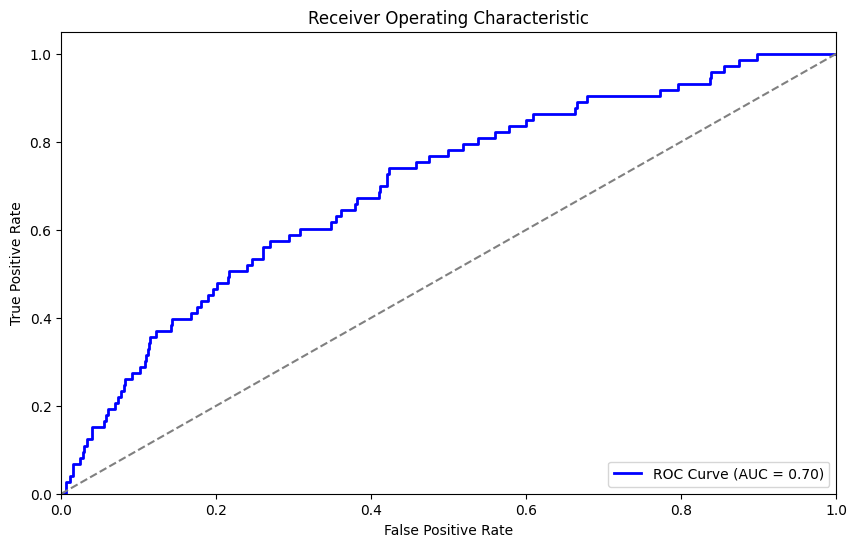


Model Coefficients:
                      Feature  Coefficient
0          num_critic_reviews     0.015898
1            num_user_reviews     0.068882
2             num_users_voted     0.259878
3                    duration    -0.283391
4   cast_total_facebook_likes    -0.188038
5     director_facebook_likes    -0.032662
6      actor_3_facebook_likes     0.034677
7      actor_2_facebook_likes    -0.181750
8      actor_1_facebook_likes    -0.185788
9                 movie_score     0.532695
10                 budget_log    -0.036842


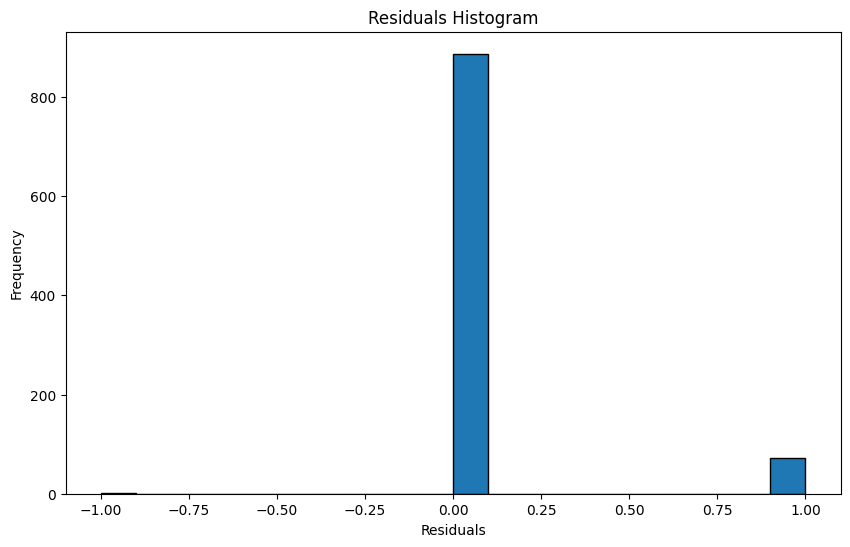

In [48]:
# log reg starter code from chat gpt
X = df[["num_critic_reviews", "num_user_reviews","num_users_voted", 'duration', 'cast_total_facebook_likes', 'director_facebook_likes',
'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes', "movie_score", "budget_log"]].fillna(0) # for sklearn

y = df["break_out_hits_ind"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Model Coefficients
print("\nModel Coefficients:")
print(pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}))

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



***

awful model doesn't really converge

## Looking at Correlations

* just starting to script and look around for patterns

<Axes: >

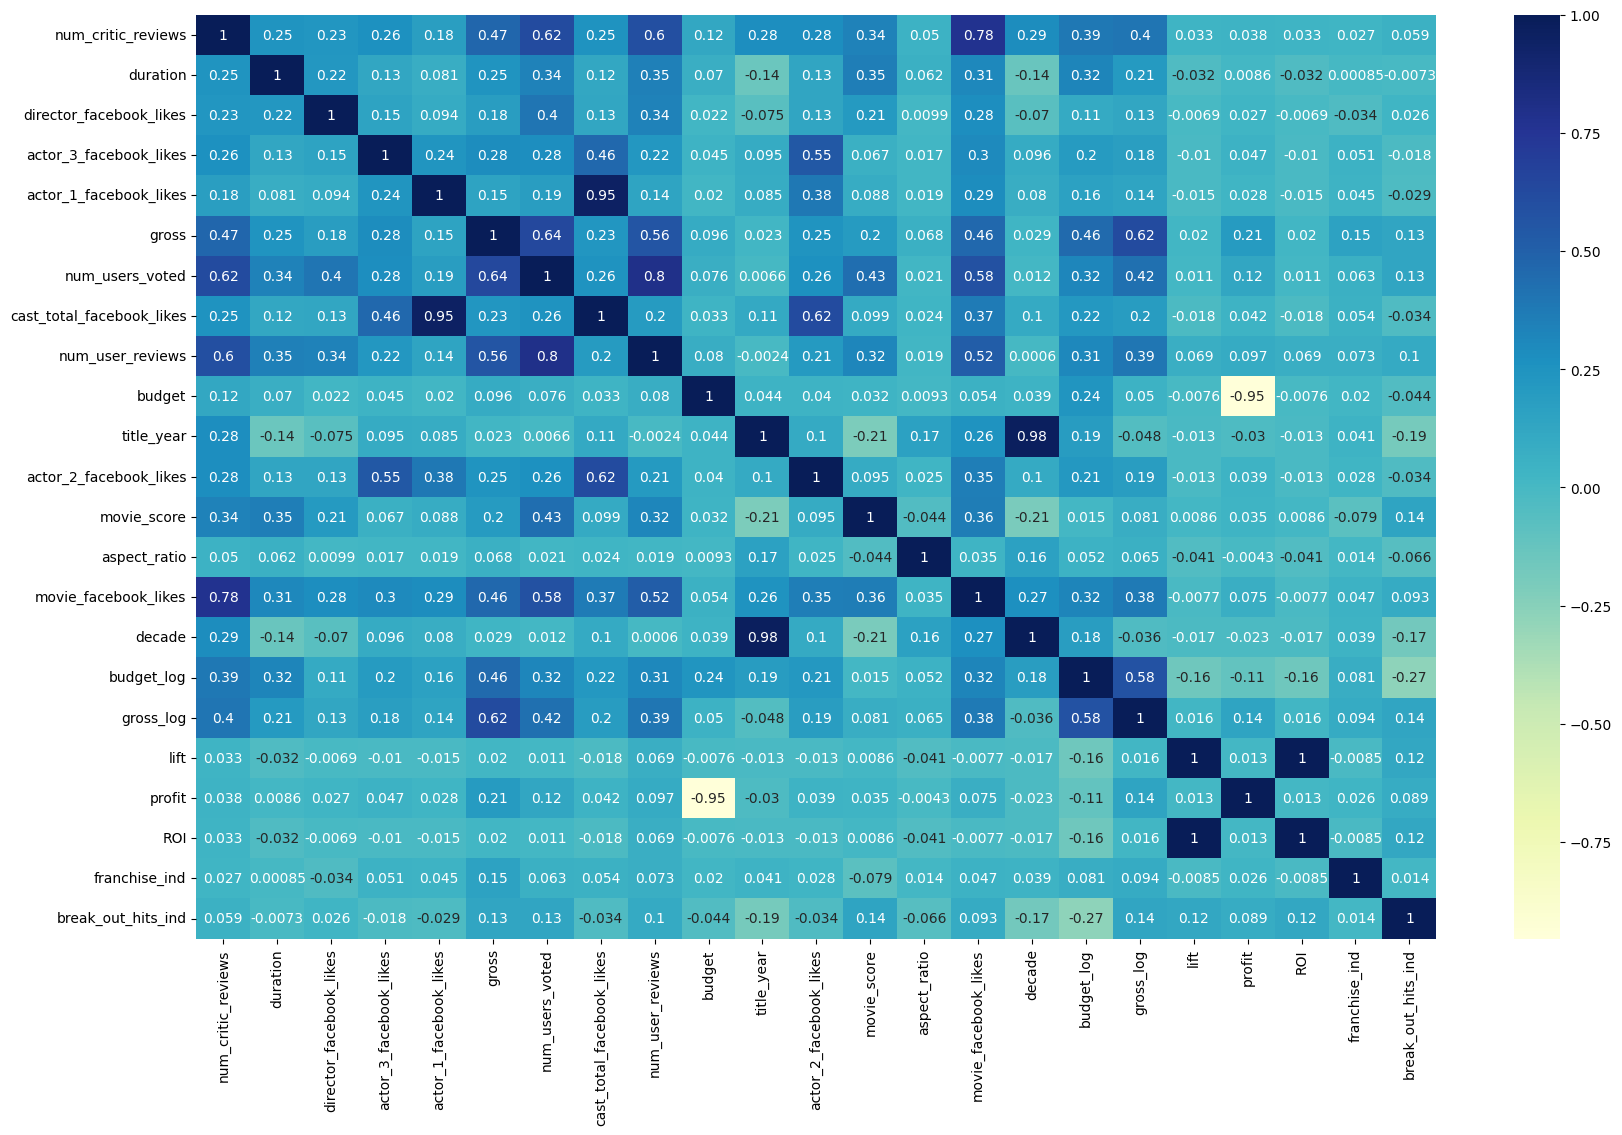

In [41]:
# test correlations -- good view or starting point
df_nums = df.select_dtypes(np.number)
df_nums = df_nums.loc[df_nums["cast_total_facebook_likes"].notnull(),]

sns.heatmap(df_nums.corr(), annot = True, cmap='YlGnBu')

,num_critic_reviews,num_user_reviews,num_users_voted
num_critic_reviews,1.000000,0.602866,0.622104
num_user_reviews,0.602866,1.000000,0.801474
num_users_voted,0.622104,0.801474,1.000000


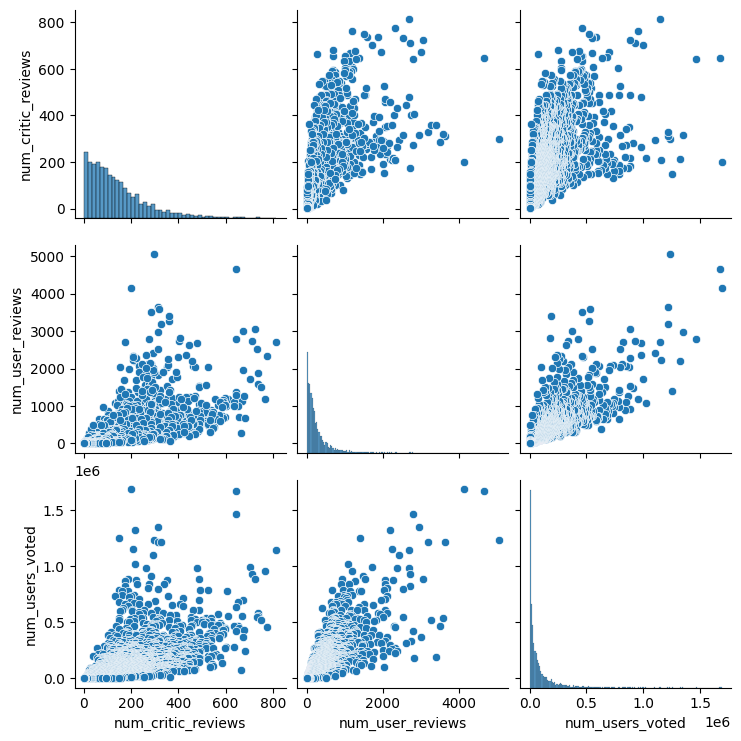

In [42]:
sns.pairplot(df[["num_critic_reviews", "num_user_reviews","num_users_voted" ]])

df[["num_critic_reviews", "num_user_reviews","num_users_voted" ]].corr()

In [43]:
cols_ = ['movie_score',
'num_critic_reviews',
'duration',
'cast_total_facebook_likes',
'budget_log',
'gross_log',
'franchise_ind',
'director_facebook_likes',
'actor_3_facebook_likes',
'actor_2_facebook_likes',
'actor_1_facebook_likes']

tmp = pg.pairwise_corr(df, cols_)

tmp.loc[tmp["X"] == "movie_score"].sort_values("r", ascending = False)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
1,movie_score,duration,pearson,two-sided,4792,0.346357,"[0.32, 0.37]",3.990806e-135,1.327e+131,1.000000
0,movie_score,num_critic_reviews,pearson,two-sided,4766,0.337604,"[0.31, 0.36]",2.230757e-127,2.465e+123,1.000000
6,movie_score,director_facebook_likes,pearson,two-sided,3927,0.209379,"[0.18, 0.24]",3.743130e-40,3.09e+36,1.000000
2,movie_score,cast_total_facebook_likes,pearson,two-sided,4772,0.099268,"[0.07, 0.13]",6.306208e-12,3.249e+08,1.000000
8,movie_score,actor_2_facebook_likes,pearson,two-sided,4741,0.095428,"[0.07, 0.12]",4.580330e-11,4.679e+07,0.999998
9,movie_score,actor_1_facebook_likes,pearson,two-sided,4772,0.087703,"[0.06, 0.12]",1.290126e-09,1.792e+06,0.999980
4,movie_score,gross_log,pearson,two-sided,4054,0.076311,"[0.05, 0.11]",1.148108e-06,2693.958,0.998176
7,movie_score,actor_3_facebook_likes,pearson,two-sided,4700,0.066924,"[0.04, 0.1]",4.389700e-06,690.941,0.995781
3,movie_score,budget_log,pearson,two-sided,4419,0.005229,"[-0.02, 0.03]",7.282322e-01,0.02,0.063941
5,movie_score,franchise_ind,pearson,two-sided,4804,-0.076227,"[-0.1, -0.05]",1.225429e-07,2.144e+04,0.999570


In [44]:
tmp.loc[tmp["X"] == "gross_log"].sort_values("r", ascending = False)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
43,gross_log,actor_2_facebook_likes,pearson,two-sided,4021,0.186883,"[0.16, 0.22]",6.318229e-33,2.019e+29,1.000000
42,gross_log,actor_3_facebook_likes,pearson,two-sided,3992,0.181170,"[0.15, 0.21]",8.415600e-31,1.578e+27,1.000000
44,gross_log,actor_1_facebook_likes,pearson,two-sided,4039,0.143817,"[0.11, 0.17]",4.115491e-20,4.051e+16,1.000000
41,gross_log,director_facebook_likes,pearson,two-sided,3357,0.128321,"[0.09, 0.16]",8.460097e-14,2.654e+10,1.000000
40,gross_log,franchise_ind,pearson,two-sided,4054,0.086250,"[0.06, 0.12]",3.793900e-08,7.258e+04,0.999803


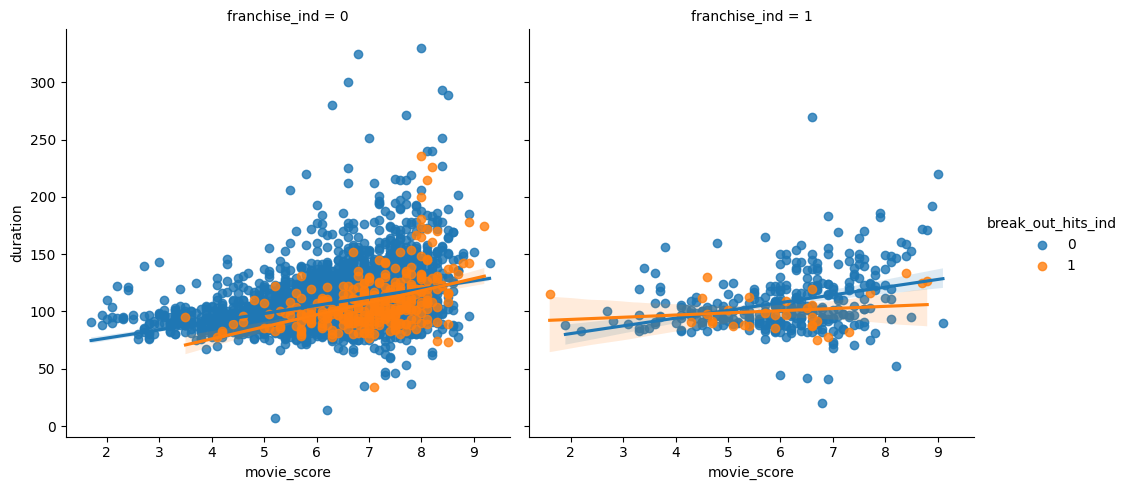

In [45]:
sns.lmplot(data = df, x = "movie_score", y = "duration", col ="franchise_ind", hue= "break_out_hits_ind")

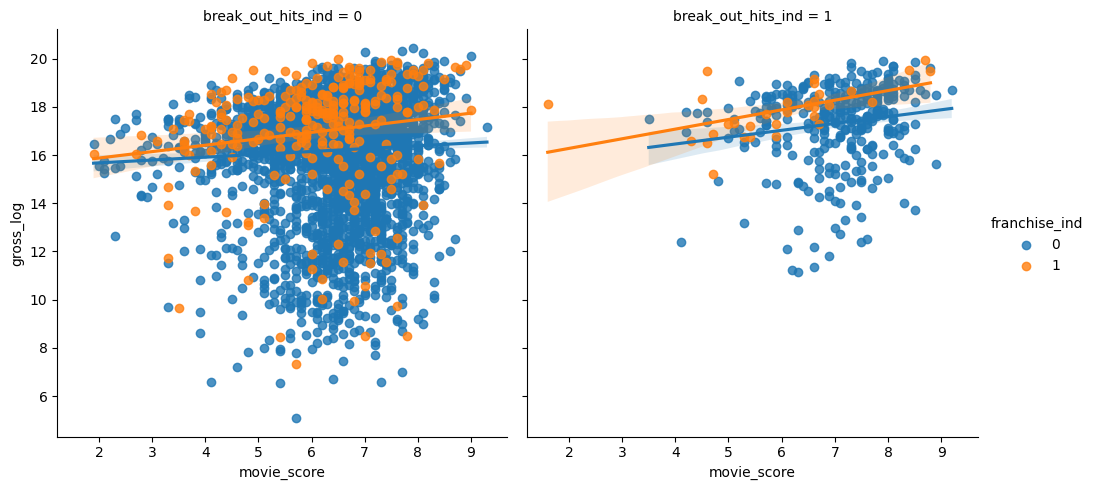

In [46]:
sns.lmplot(data = df, x = "movie_score", y = "gross_log", hue ="franchise_ind", col= "break_out_hits_ind")

***
* Nothing here, really need to do a proper regression analysis